In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
import geopandas as gpd

import re
import numpy as np
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords

import json
from collections import defaultdict

In [6]:
data = pd.read_pickle("../data_subs.pkl")

# Which country is named most?

In [4]:
map_df = gpd.read_file("../mapdata/World_Countries.shp")

len(list(map_df["COUNTRY"]))

252

In [5]:
map_df = gpd.read_file("../mapdata/World_Countries.shp")
couns = list(map_df["COUNTRY"]) + ["USA", "America"]
# couns = [re.match(r"(.*) \(.*\)", c).groups()[0] if "(" in c else c for c in couns]

country_counts = []
cols = ["summary", "subtitles"]

for c in couns:
   
    all_counts = {}
    for col in cols:
        counts = {"total": 0, "doc": 0}
        for elem in data[col]:
            count = elem.count(c)
            counts["total"] += count
            if count > 0:
                counts["doc"] += 1
        all_counts[col] = counts
    
    country_counts.append((c, all_counts))

In [9]:
cols = ["country", "summary_doc", "summary_total", "subtitles_doc", "subtitles_total"]
count_data = {"country" : [c[0] for c in country_counts]}

for col in cols[1:]:
    field, count_type = col.split("_")
    count_data[col] = [c[1][field][count_type] for c in country_counts]

count_data = pd.DataFrame(count_data, columns=cols)
count_data = (count_data.replace({"country": {"America": "United States", "USA": "United States"}})
    .groupby("country", sort=False, as_index=False).sum())
count_data = count_data.sort_values(["subtitles_total", "subtitles_doc"], ascending=False)

## Top n

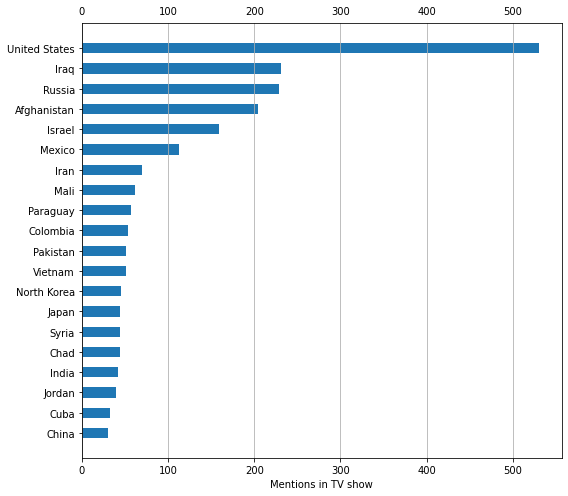

In [7]:
n = 20
fig, ax = plt.subplots(1, figsize=(8,.35*n))
ax.barh([i for i in range(n)], width=list(count_data["subtitles_total"][n-1::-1]), height=.5, tick_label=list(count_data["country"][n-1::-1]), color="C0")
plt.tick_params(labeltop=True)
plt.grid(axis="x")
ax.set_xlabel("Mentions in TV show")
fig.tight_layout()

fig.savefig(f"top_{n}_countries.png", dpi=300)

## On Worldmap

In [8]:
merged = map_df.set_index("COUNTRY").join(count_data.set_index("country"))
merged.head()

,geometry,summary_doc,summary_total,subtitles_doc,subtitles_total
COUNTRY,,,,,
Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0,0,0,0
Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ...",0,0,0,0
Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853...",10,10,69,204
Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236...",0,0,3,3
Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38...",0,0,0,0


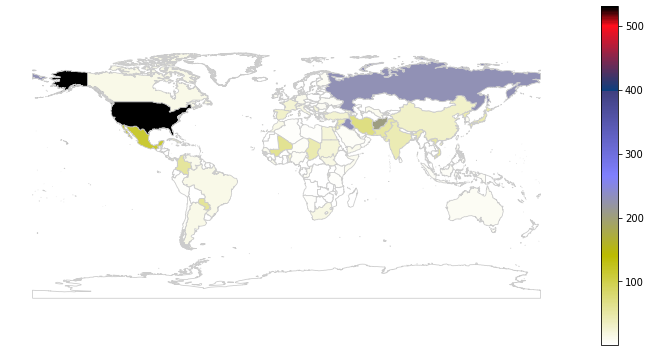

In [105]:
col = "subtitles_total"

vmin, vmax = 1, max(merged[col])

fig, ax = plt.subplots(1, figsize=(10, 5))

cmap="gist_stern_r"

merged.plot(column=col, cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8")
ax.axis("off")

#norm=colors.LogNorm(vmin=vmin, vmax=vmax)
norm=plt.Normalize(vmin=vmin, vmax=vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

fig.colorbar(sm)
fig.tight_layout()

fig.savefig("wordmap.png", dpi=300)

# Sentiments for top n countries

In [10]:
cols = ["country", "positive", "negative", "neutral"]
sentiment_data = {c:[] for c in cols}
sentiment_data["country"] = list(count_data["country"][:20])

In [11]:
country_sentances = defaultdict(list)
for sub in data["subtitles"]:
    sentances = sent_tokenize(sub)
    for sent in sentances:
        for c in sentiment_data["country"]:
            if c in sent:
                country_sentances[c].append(sent)
country_sentances = dict(country_sentances)

In [11]:
for c in sentiment_data["country"]:
    counter = {s: 0 for s in ["negative", "neutral", "positive"]}
    
    for sent in country_sentances[c]:
        tb = TextBlob(sent)
        
        if tb.sentiment.polarity < -.33:
            counter["negative"] += 1
        elif -.33 <= tb.sentiment.polarity < .33:
            counter["neutral"] += 1
        elif .33 <= tb.sentiment.polarity:
            counter["positive"] += 1
    
    for sentiment, count in counter.items():
        sentiment_data[sentiment].append(count)

In [12]:
sentiment_data = pd.DataFrame(sentiment_data, columns=cols)

In [20]:
pos_ratio = []
neg_ratio = []

for pos, neg in zip(sentiment_data["positive"], sentiment_data["negative"]):
    pos_ratio.append(pos/(pos+neg))
    neg_ratio.append(neg/(pos+neg))

sentiment_data["positive_ratio"] = pos_ratio
sentiment_data["negative_ratio"] = neg_ratio

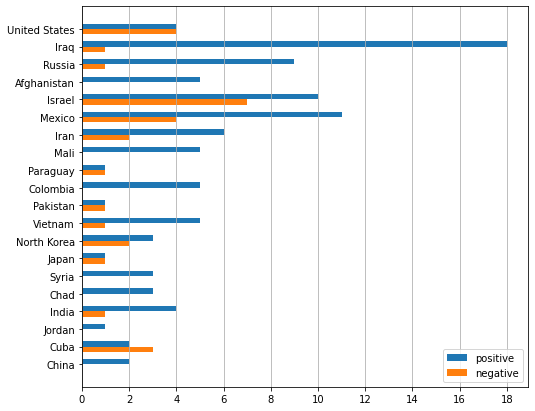

In [57]:
fig, ax = plt.subplots(1, figsize=(8, .35*20))
spacing = np.arange(20)
height = .3

ax.barh(spacing, sentiment_data["positive"], height=height, color="C0", label="positive")
ax.barh(spacing+height, sentiment_data["negative"], height=height, color="C1", label="negative")

ax.set_yticks(spacing+.5*height)
ax.set_yticklabels(sentiment_data["country"])

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.gca().invert_yaxis()
ax.grid(axis="x")

ax.legend()

fig.savefig("sentiments.png", dpi=300)

## Most frequent words in context of country

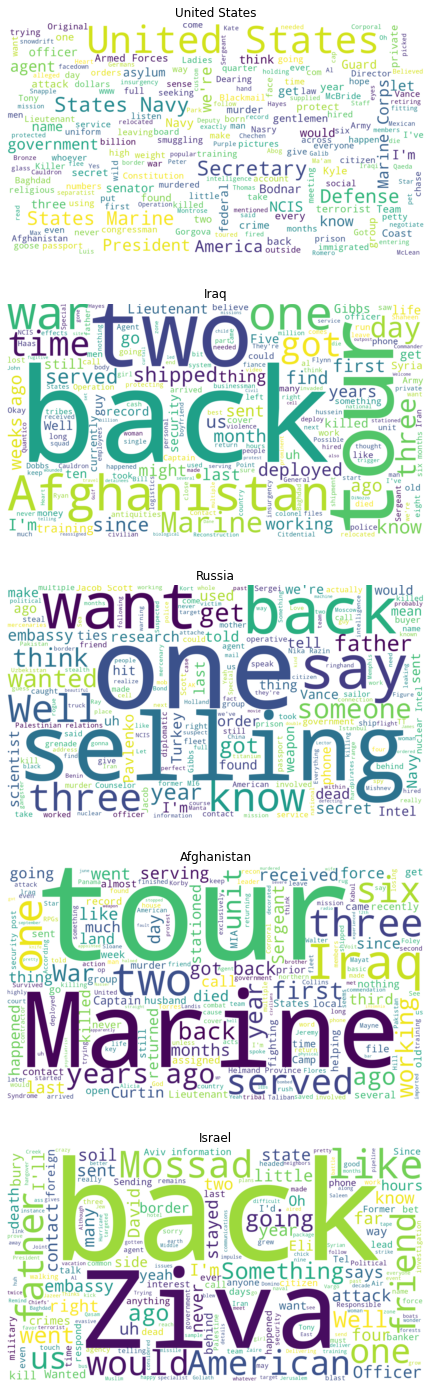

In [22]:
countries = ["United States", "Iraq", "Russia", "Afghanistan", "Israel"]

fig, axes = plt.subplots(len(countries), figsize=(10, len(countries)*5))
for coun, ax in zip(countries, axes):
    new_text = " ".join(country_sentances[coun])
    sw = stopwords.words("english") + [coun, coun+"i", coun+"n", coun+"is", coun+"ns"]
    wordcloud = WordCloud(background_color="white", width=1920, height=1080, stopwords=sw).generate(new_text)
    ax.imshow(wordcloud, interpolation = "bilinear")
    ax.axis("off")
    ax.set_title(coun)
fig.savefig("wordclouds.png", dpi=300)